# SMART Metrics Forecasting

In previous notebooks in this project, we explored how machine learning models can be trained to predict whether a hard drive would fail or not in a given future time interval. The ceph team believes that in addition to the predictions provided by these models, another piece of information that users would find helpful is the forecast of values of specific SMART metrics coming from their hard drives.

In this notebook, we explore how time series forecasting models can be used to predict future values of SMART metrics.

In [1]:
# imports
import pdb
import datetime as dt
from IPython.display import display

import numpy as np
import pandas as pd

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

from fbprophet import Prophet

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso

In [2]:
# dask tasks progress bar
pbar = ProgressBar()
pbar.register()

# Read Data

In this section we'll read in the data to be used for training models. For this notebook, we'll use the open source backblaze hard drive dataset. Since the dataset is quite large, it might not fit in memory for all devices. So we'll use dask for lazy and parallel processing. Note that we are only using one quarter worth of data for this POC, but we can increase this for production models.

In [3]:
# read df and keep seagate data
df = dd.read_parquet(
    path='../data/interim/data_Q3_2020_parquet',
)
df = df[(df['model'].str.startswith('S')) | (df['model'].str.startswith('ZA'))]

In [4]:
# failed vs working serials
failed_serials = df[df['failure']==1]['serial_number'].unique().compute().values
all_serials = df['serial_number'].unique().compute().values
working_serials = np.setdiff1d(all_serials, failed_serials)

[########################################] | 100% Completed | 48.8s
[########################################] | 100% Completed | 49.1s


# Clean Data

In this section we will clean up the data. We'll begin with a small set of smart metrics to use for training (`smart_stats_to_keep`). Then we'll determine which columns have the most amount of missing data, and if this missing data is specific to models. Based on this information we'll refine the smart metrics being kept in the dataset (i.e. update the `smart_stats_to_keep` and re-rerun the following cells). Finally, from the results in the analysis here, we'll determine data from which serial numbers (i.e. hard drives) should be kept so that we have a clean dataset.

In [5]:
# set which columns are metadata and which ones are smart attribuetes
meta_cols = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure']

# set which columns to use in analysis
# NOTE: this determined based on backblaze research, ibm paper, and SMART wiki
smart_stats_to_keep = [
    5,
    10,
#     184,    # too many nans
    187,
    188,
    197,
    198,
#     222,    # too many nans
]
smart_cols = [f'smart_{i}_raw' for i in smart_stats_to_keep]
smart_cols += [f'smart_{i}_normalized' for i in smart_stats_to_keep]

## Failed Drives Data

In [6]:
# how much data is missing, device-wise and feature-wise
serialwise_featurewise_pct_nans = df[df['serial_number'].isin(failed_serials)][['serial_number']+smart_cols]\
        .groupby('serial_number')\
        .apply(lambda x: x.isna().mean())\
        .compute()

mean_serialwise_pct_nans = serialwise_featurewise_pct_nans.mean(axis=1).sort_values(ascending=False)
mean_serialwise_pct_nans.head(15)

[                                        ] | 0% Completed |  0.0s

/opt/app-root/src/.local/share/virtualenvs/ceph_drive_failure-6l7He7yy/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

`meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result



[########################################] | 100% Completed | 56.1s


serial_number
7LZ022BP          0.923077
7LZ045HN          0.923077
S2ZYJ9GGB04771    0.307692
S2ZYJ9GGB04761    0.307692
S2ZYJ9FFB18437    0.307692
S2ZYJ9CF504020    0.307692
S2ZYJ9FG404851    0.307692
S2ZYJ9KG303913    0.307692
ZA180XLA          0.014652
ZHZ3SPDW          0.000000
ZA18GX05          0.000000
ZCH080S9          0.000000
ZA12MET8          0.000000
ZA180Q9Q          0.000000
ZJV1BTSY          0.000000
dtype: float64

In [7]:
# peek at a few samples to better understand how the nans occur

# dive with 90% data missing
print('7LZ022BP')
print(df[df['serial_number']=='7LZ022BP'][smart_cols].isna().mean().compute().sort_values(ascending=False))

# drive with 1% data missing
print('ZA180XLA')
print(df[df['serial_number']=='ZA180XLA'][smart_cols].isna().mean().compute().sort_values(ascending=False))

# drive with 30% data missing
print('S2ZYJ9GGB04771')
print(df[df['serial_number']=='S2ZYJ9GGB04771'][smart_cols].isna().mean().compute().sort_values(ascending=False))

7LZ022BP
[########################################] | 100% Completed | 49.8s
smart_198_normalized    1.0
smart_197_normalized    1.0
smart_188_normalized    1.0
smart_187_normalized    1.0
smart_10_normalized     1.0
smart_5_normalized      1.0
smart_198_raw           1.0
smart_197_raw           1.0
smart_188_raw           1.0
smart_187_raw           1.0
smart_10_raw            1.0
smart_5_raw             1.0
dtype: float64
ZA180XLA
[########################################] | 100% Completed | 50.2s
smart_198_normalized    0.015873
smart_197_normalized    0.015873
smart_188_normalized    0.015873
smart_187_normalized    0.015873
smart_10_normalized     0.015873
smart_5_normalized      0.015873
smart_198_raw           0.015873
smart_197_raw           0.015873
smart_188_raw           0.015873
smart_187_raw           0.015873
smart_10_raw            0.015873
smart_5_raw             0.015873
dtype: float64
S2ZYJ9GGB04771
[########################################] | 100% Completed | 49.3s
s

**NOTE** From above samples we can see that nans occur either when a very few number of rows are missing, or when entire columns are missing.

In [8]:
# keep only devices that have no missing data
failed_ts_df = df[
    df['serial_number'].isin(
        mean_serialwise_pct_nans[mean_serialwise_pct_nans==0].index
    )
][meta_cols + smart_cols].compute()

[########################################] | 100% Completed | 48.5s


## Working Drives Data

In [9]:
# how much data is missing, device-wise and feature-wise 
serialwise_featurewise_pct_nans = df[df['serial_number'].isin(working_serials)][['serial_number']+smart_cols]\
        .groupby('serial_number')\
        .apply(lambda x: x.isna().mean())\
        .compute()

mean_serialwise_pct_nans = serialwise_featurewise_pct_nans.mean(axis=1).sort_values(ascending=False)
mean_serialwise_pct_nans.head(15)

[                                        ] | 0% Completed |  0.1s

/opt/app-root/src/.local/share/virtualenvs/ceph_drive_failure-6l7He7yy/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

`meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result



[########################################] | 100% Completed |  2min 55.0s


serial_number
7LZ01GHG    0.923077
7LZ01NDE    0.923077
7LZ032RA    0.923077
7LZ029KM    0.923077
NB120H9S    0.923077
NB1206GH    0.923077
7QT01D0F    0.923077
7QT01BPW    0.923077
7QT00H3G    0.923077
7LZ047MH    0.923077
7LZ045BC    0.923077
7LZ044SF    0.923077
7LZ036NC    0.923077
7LZ036LY    0.923077
7LZ02ZPX    0.923077
dtype: float64

In [10]:
# downsample working drives data - randomly select for now, use clustering in
# later improvement iterations
pct_working_to_keep = 0.00125
num_working_to_keep = int(pct_working_to_keep*len(working_serials))

# keep devices that have no missing data
working_ts_df = df[
    df['serial_number'].isin(
        mean_serialwise_pct_nans[mean_serialwise_pct_nans==0].index[:num_working_to_keep]
    )
][meta_cols + smart_cols].compute()

[########################################] | 100% Completed | 48.5s


In [11]:
# amount of clean data left to work with
working_ts_df.shape, failed_ts_df.shape

((12405, 17), (11735, 17))

In [12]:
# how much failing drive data do we lose?
dd.compute(df[df['serial_number'].isin(failed_serials)].shape)

[########################################] | 100% Completed | 49.7s


((12242, 131),)

In [13]:
# wont need dask anymore
pbar.unregister()

## Results

By dropping nans, we only lost about 4% of the data (for failed hard drives). Since this does not seem like a completely unreasonable number, we won't do any other data cleaning gymnastics here. The data that we have now is clean and ready for building forecasting models.

# Build Forecasting Models

In this section we will create forecasting models using the clean data from above section. You can play around with the these variables in the cell below to configure the prediction settings.

- `Y_COLS`: The metric to forecast. Since smart 5 was determined to be a valueable indicator of failure, we'll use smart 5 as the default.
- `X_COLS`: Other features available. Some time series models can make use of other features too for generating a forecast. We will use smart 10, 187, 188, 197 and 198 as these additional features. These were determined to be useful from Google research, IBM research, backblaze, and the smart metrics wiki.
- `NDAYS_DATA`: How many days of data available in at runtime. Since the `diskprediction_local` module of ceph stores only 6 days of smart data, our models will only have that much data available.
- `NDAYS_TO_PREDICT`: How many days into the future to forecast. Since we have a short amount of historical data, we will be forecasting for a short period too.

In [14]:
# training setup config
Y_COLS = ['smart_5_normalized']
y_smart_stats = set([col.split('_')[1] for col in Y_COLS])

X_COLS = [c for c in smart_cols if c.split('_')[1] not in y_smart_stats]

NDAYS_DATA = 6
NDAYS_TO_PREDICT = 6

In [15]:
# set date column as index
working_ts_df = working_ts_df.set_index('date')
failed_ts_df = failed_ts_df.set_index('date')

## Baseline

In this section we will fit baseline models for the forecasting task. We will compare the performance of the ML models with this baseline to gauge how informative are the models. The baseline model here is one that predicts the next N days will be the same as today.

In [16]:
def get_baseline_mses_windowwise(drive_ts):
    """
    Predict the next N days the value will be same as today.
    Calculate MSE at the end of each training window
    """
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)):
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - drive_ts[Y_COLS[0]].iloc[end_idx])**2).mean()
        
    return mses

### Failed Drives

In [17]:
# calculate baseline
baseline_mses = failed_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses = baseline_mses.to_frame('mse_baseline')

# mse on each day
print('MSE for each drive for each train-forecast window:\n\n', baseline_mses, end='\n\n')

# average mse across days
print('Average MSE for each drive:\n\n', baseline_mses.mean(level=0), end='\n\n')

MSE for each drive for each train-forecast window:

 serial_number  date      
S300WFGR       2020-07-01   NaN
               2020-07-02   NaN
S300Z4TZ       2020-07-01   NaN
               2020-07-02   NaN
               2020-07-03   NaN
                             ..
ZLW0GPC5       2020-07-01   NaN
               2020-07-02   NaN
               2020-07-03   NaN
               2020-07-04   NaN
               2020-07-05   NaN
Length: 11735, dtype: float64

Average MSE for each drive:

 serial_number
S300WFGR          NaN
S300Z4TZ     0.031410
S300Z7P1     0.000000
S301FDQW    10.322619
S301GMWQ     0.000000
              ...    
ZLW0G6CE     0.000000
ZLW0G6FJ          NaN
ZLW0GK7E     0.000000
ZLW0GKE4     0.000000
ZLW0GPC5          NaN
Length: 272, dtype: float64



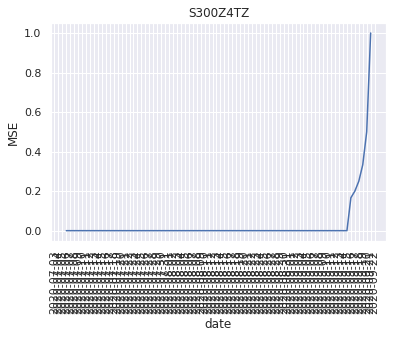

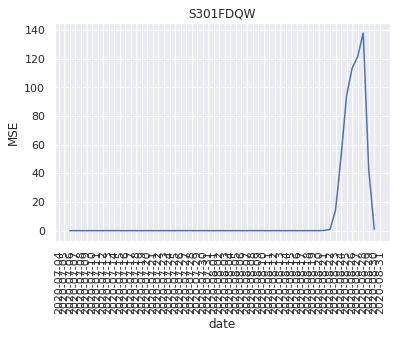

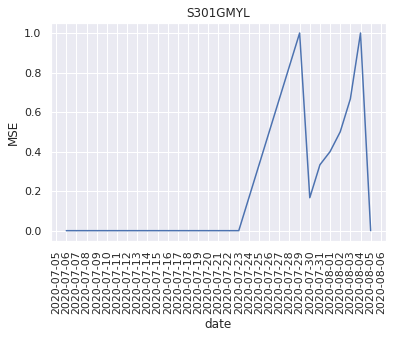

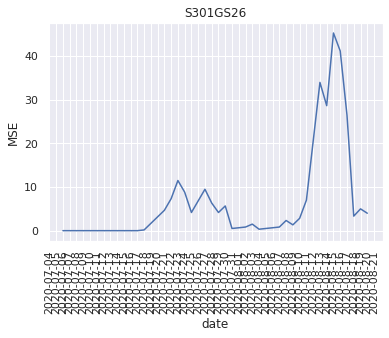

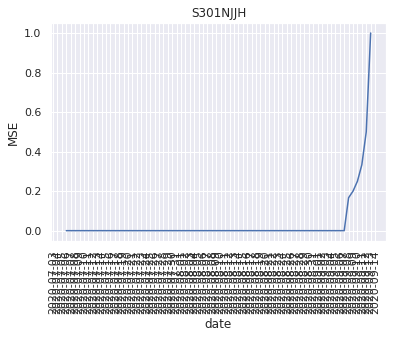

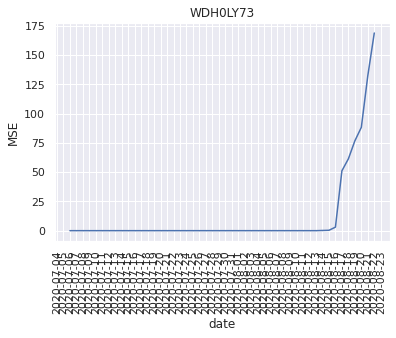

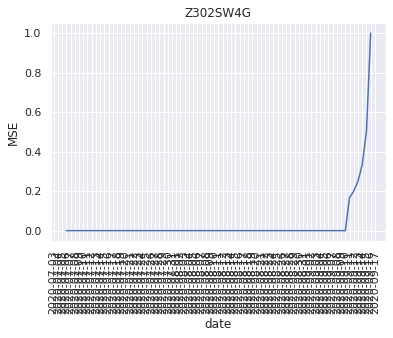

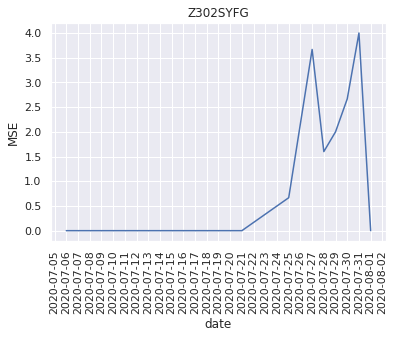

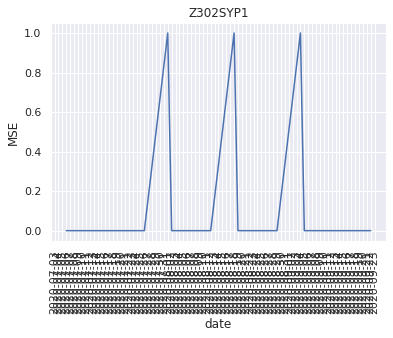

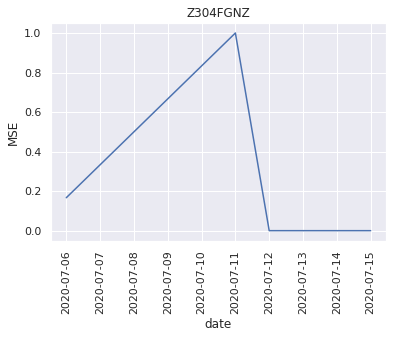

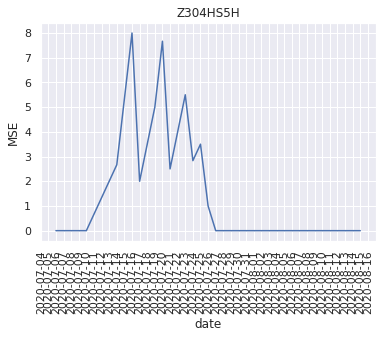

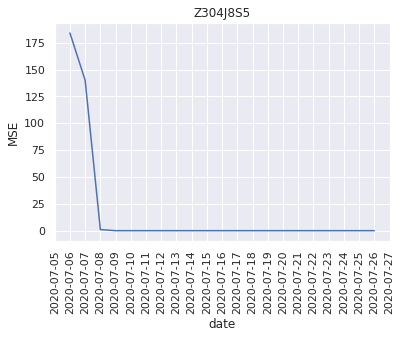

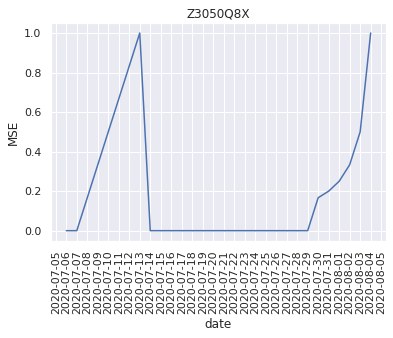

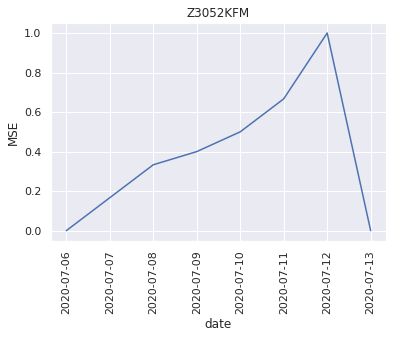

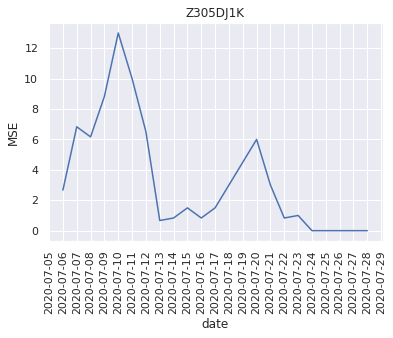

In [18]:
# visualize how mses change over time when using baseline strategy
i = 0
to_plot = 15
for ser in baseline_mses.index.get_level_values(0).unique():
    # get mse for each day/window
    ser_mses = baseline_mses.loc[ser]
    
    # dont plot if all nans
    if not ser_mses.isna().all():
    
        # dont plot if the metric to predict has had the same value till fail
        if failed_ts_df[failed_ts_df['serial_number']==ser][Y_COLS[0]].std():
            sns.lineplot(
                x=ser_mses.index,
                y=ser_mses.values,
            )
            plt.title(ser)
            plt.ylabel('MSE')
            plt.xticks(rotation=90)
            plt.show()
            
            # dont plot everything
            i += 1
            if i==to_plot:
                break

### Results

From the above graphs, we can see that the baseline strategy works fine when the hard drive is healthy i.e. shows no symptoms of failure. However, as it approaches end of life the error in baseline model predictions rises significantly. So it might seem like a good strategy but it actually provides very little information when it is needed the most.

### Working Drives

In [19]:
# calculate baseline for healthy drives
baseline_mses_working = working_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses_working = baseline_mses_working.to_frame('mse_baseline')

# mse on each day
print('MSE for each drive for each train-forecast window:\n\n', baseline_mses_working, end='\n\n')

# average mse across days
print('Average MSE for each drive:\n\n', baseline_mses_working.mean(level=0), end='\n\n')

MSE for each drive for each train-forecast window:

 serial_number  date      
S300VKRB       2020-07-01   NaN
               2020-07-02   NaN
               2020-07-03   NaN
               2020-07-04   NaN
               2020-07-05   NaN
                             ..
ZR50121P       2020-09-26   NaN
               2020-09-27   NaN
               2020-09-28   NaN
               2020-09-29   NaN
               2020-09-30   NaN
Length: 12405, dtype: float64

Average MSE for each drive:

 serial_number
S300VKRB    0.0
S300VLKS    0.0
S300WE24    0.0
S300WE6K    0.0
S300WEAV    0.0
           ... 
ZHZ656DW    0.0
ZHZ65C16    0.0
ZJV009E3    0.0
ZJV00AR3    0.0
ZR50121P    NaN
Length: 136, dtype: float64



In [20]:
# what is the WORST average mse using baseline strategy
baseline_mses_working.mean(level=0).max()

0.040697674418604654

### Results

From the above results, it seems that baseline model works extremely well for healthy drives (MSE=0 for most hard drives). The graphs in the section above also indicated the same thing - there is barely any unexpected change in these SMART metrics when the drive is healthy. Therefore in the following sections we will evaluate models only on failed data, since any model would likely be decently performant (if not perfect) for healthy drives. 

## Linear Regression

In [21]:
# calculate windowwise mse for ols model for each drive
def get_linreg_mses_windowwise(drive_ts):
    # define model
    model = LinearRegression(
        normalize=True,
    )

    # create dummy exogenous variable (train)
    dummy_xtrain = np.arange(start=0, stop=NDAYS_DATA).reshape(-1, 1)
    
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        # create dummy exogenous variable (test)
        dummy_xtest = np.arange(
            start=NDAYS_DATA, 
            stop=NDAYS_DATA + min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
        ).reshape(-1, 1)

        # fit model
        model.fit(
            X=dummy_xtrain,
            y=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
        )
        
        # predict and get mse
        preds = model.predict(dummy_xtest).flatten()
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_linreg_mses_windowwise)

In [22]:
# update all results df and compare
all_mses['mse_linreg'] = windowwise_mses

# mse on each day
print('MSE for each drive for each train-forecast window:')
display(all_mses[['mse_baseline', 'mse_linreg']])

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_linreg']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_linreg']-mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

MSE for each drive for each train-forecast window:


mse_baseline  mse_linreg
serial_number date                                
S300WFGR      2020-07-01           NaN         NaN
              2020-07-02           NaN         NaN
S300Z4TZ      2020-07-01           NaN         NaN
              2020-07-02           NaN         NaN
              2020-07-03           NaN         NaN
...                                ...         ...
ZLW0GPC5      2020-07-01           NaN         NaN
              2020-07-02           NaN         NaN
              2020-07-03           NaN         NaN
              2020-07-04           NaN         NaN
              2020-07-05           NaN         NaN

[11735 rows x 2 columns]

Avg. MSE for each drive:


,mse_baseline,mse_linreg
serial_number,,
ZCH0EA28,381.806250,148.840343
ZCH0CCSY,736.158333,612.876751
ZJV5M9KA,460.544444,378.915628
ZCH074SE,169.000000,157.084444
ZA1819E9,11.441667,4.145687
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 1.5228603706772657


In [23]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,958.666667,57.512789
2020-07-07,973.333333,59.737506
2020-07-08,479.833333,227.104444
2020-07-09,122.200000,473.360000


## Lasso

In [ ]:
# calculate windowwise mse for lasso model for each drive
def get_lasso_mses_windowwise(drive_ts):
    # define model
    model = Lasso(
        normalize=True,
        random_state=42,
    )

    # create dummy exogenous variable (train)
    dummy_xtrain = np.arange(start=0, stop=NDAYS_DATA).reshape(-1, 1)
    
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        # create dummy exogenous variable (test)
        dummy_xtest = np.arange(
            start=NDAYS_DATA, 
            stop=NDAYS_DATA + min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
        ).reshape(-1, 1)

        # fit model
        model.fit(
            X=dummy_xtrain,
            y=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
        )
        
        # predict and get mse
        preds = model.predict(dummy_xtest).flatten()
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_lasso_mses_windowwise)

In [25]:
# update all results df and compare
all_mses['mse_lasso'] = windowwise_mses

# mse on each day
print('MSE for each drive for each train-forecast window:')
display(all_mses[['mse_baseline', 'mse_lasso']])

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_lasso']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_lasso']-mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

MSE for each drive for each train-forecast window:


mse_baseline  mse_lasso
serial_number date                               
S300WFGR      2020-07-01           NaN        NaN
              2020-07-02           NaN        NaN
S300Z4TZ      2020-07-01           NaN        NaN
              2020-07-02           NaN        NaN
              2020-07-03           NaN        NaN
...                                ...        ...
ZLW0GPC5      2020-07-01           NaN        NaN
              2020-07-02           NaN        NaN
              2020-07-03           NaN        NaN
              2020-07-04           NaN        NaN
              2020-07-05           NaN        NaN

[11735 rows x 2 columns]

Avg. MSE for each drive:


,mse_baseline,mse_lasso
serial_number,,
ZCH0EA28,381.806250,89.382469
ZJV5M9KA,460.544444,417.703068
ZCH0CCSY,736.158333,707.688888
S300Z4TZ,0.031410,0.031410
ZCH083F6,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.1446787476441166


In [26]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg,mse_lasso
date,,,
2020-07-01,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN
2020-07-05,NaN,NaN,NaN
2020-07-06,958.666667,57.512789,209.017283
2020-07-07,973.333333,59.737506,82.382696
2020-07-08,479.833333,227.104444,64.721416
2020-07-09,122.200000,473.360000,188.592501


## Bayesian Ridge Regression

In [27]:
# calculate windowwise mse for br model for each drive
def get_br_mses_windowwise(drive_ts):
    # define model
    model = BayesianRidge(
        normalize=True,
    )

    # create dummy exogenous variable (train)
    dummy_xtrain = np.arange(start=0, stop=NDAYS_DATA).reshape(-1, 1)
    
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        
        # create dummy exogenous variable (test)
        dummy_xtest = np.arange(
            start=NDAYS_DATA, 
            stop=NDAYS_DATA + min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
        ).reshape(-1, 1)

        # fit model
        model.fit(
            X=dummy_xtrain,
            y=drive_ts[Y_COLS[0]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
        )
        
        # predict and get mse
        preds = model.predict(dummy_xtest).flatten()
        
        if np.isnan(preds).any():
            pdb.set_trace()
            
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_br_mses_windowwise)

In [28]:
# update all results df and compare
all_mses['mse_br'] = windowwise_mses

# mse on each day
print('MSE for each drive for each train-forecast window:')
display(all_mses[['mse_baseline', 'mse_br']])

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_br']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_br']-mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

MSE for each drive for each train-forecast window:


mse_baseline  mse_br
serial_number date                            
S300WFGR      2020-07-01           NaN     NaN
              2020-07-02           NaN     NaN
S300Z4TZ      2020-07-01           NaN     NaN
              2020-07-02           NaN     NaN
              2020-07-03           NaN     NaN
...                                ...     ...
ZLW0GPC5      2020-07-01           NaN     NaN
              2020-07-02           NaN     NaN
              2020-07-03           NaN     NaN
              2020-07-04           NaN     NaN
              2020-07-05           NaN     NaN

[11735 rows x 2 columns]

Avg. MSE for each drive:


,mse_baseline,mse_br
serial_number,,
ZCH0EA28,381.806250,142.547238
ZCH0CCSY,736.158333,635.306334
ZJV5M9KA,460.544444,400.676324
ZA1819E9,11.441667,4.100040
ZCH074SE,169.000000,162.721665
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 1.3640115323365776


In [29]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg,mse_lasso,mse_br
date,,,,
2020-07-01,NaN,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN,NaN
2020-07-05,NaN,NaN,NaN,NaN
2020-07-06,958.666667,57.512789,209.017283,66.331898
2020-07-07,973.333333,59.737506,82.382696,57.570863
2020-07-08,479.833333,227.104444,64.721416,219.038516
2020-07-09,122.200000,473.360000,188.592501,457.571010


## ARIMA

In [ ]:
# calculate windowwise mse for arima model for each drive
def get_arima_mses_windowwise(drive_ts):
    mses = pd.Series(index=drive_ts.index)
    
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)):
        try:
            # init model and train
            model = ARIMA(
                endog=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
                order=(1, 1, 0),
                freq='D',
            )
            model = model.fit()
            
            # forecast and calculate error
            preds = model.forecast(steps=NDAYS_TO_PREDICT)
            mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()

        # value errors occur when dates are not continuous
        except ValueError as ve:
            mses.iloc[end_idx] = np.nan
            
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_arima_mses_windowwise)

In [31]:
# update all results df and compare
all_mses['mse_arima'] = windowwise_mses

# mse on each day
print('MSE for each drive for each train-forecast window:')
display(all_mses[['mse_baseline', 'mse_arima']])

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_arima']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_arima']-mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

MSE for each drive for each train-forecast window:


mse_baseline  mse_arima
serial_number date                               
S300WFGR      2020-07-01           NaN        NaN
              2020-07-02           NaN        NaN
S300Z4TZ      2020-07-01           NaN        NaN
              2020-07-02           NaN        NaN
              2020-07-03           NaN        NaN
...                                ...        ...
ZLW0GPC5      2020-07-01           NaN        NaN
              2020-07-02           NaN        NaN
              2020-07-03           NaN        NaN
              2020-07-04           NaN        NaN
              2020-07-05           NaN        NaN

[11735 rows x 2 columns]

Avg. MSE for each drive:


,mse_baseline,mse_arima
serial_number,,
ZCH0EA28,381.806250,267.692262
ZCH0CCSY,736.158333,661.323586
ZCH074SE,169.000000,145.534586
ZA12RB44,4.000000,0.133154
ZA16DDTZ,9.000000,5.670446
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.7232415451033791


In [32]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg,mse_lasso,mse_br,mse_arima
date,,,,,
2020-07-01,NaN,NaN,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN,NaN,NaN
2020-07-05,NaN,NaN,NaN,NaN,NaN
2020-07-06,958.666667,57.512789,209.017283,66.331898,628.750569
2020-07-07,973.333333,59.737506,82.382696,57.570863,524.365544
2020-07-08,479.833333,227.104444,64.721416,219.038516,48.255805
2020-07-09,122.200000,473.360000,188.592501,457.571010,530.488499


## SARIMAX

In [ ]:
# calculate windowwise mse for sarimax model for each drive
def get_sarimax_mses_windowwise(drive_ts):
    mses = pd.Series(index=drive_ts.index)

    for end_idx in range(NDAYS_DATA-1, len(drive_ts)):
        try:
            model = SARIMAX(
                endog=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
                order=(1, 1, 0),
                freq='D',
            )
            model = model.fit()
            preds = model.forecast(steps=NDAYS_TO_PREDICT)
            mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
        except ValueError as ve:
            mses.iloc[end_idx] = np.nan
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_sarimax_mses_windowwise)

In [34]:
# update all results df and compare
all_mses['mse_sarimax'] = windowwise_mses

# mse on each day
print('MSE for each drive for each train-forecast window:')
display(all_mses[['mse_baseline', 'mse_sarimax']])

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_sarimax']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_sarimax']-mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

MSE for each drive for each train-forecast window:


mse_baseline  mse_sarimax
serial_number date                                 
S300WFGR      2020-07-01           NaN          NaN
              2020-07-02           NaN          NaN
S300Z4TZ      2020-07-01           NaN          NaN
              2020-07-02           NaN          NaN
              2020-07-03           NaN          NaN
...                                ...          ...
ZLW0GPC5      2020-07-01           NaN          NaN
              2020-07-02           NaN          NaN
              2020-07-03           NaN          NaN
              2020-07-04           NaN          NaN
              2020-07-05           NaN          NaN

[11735 rows x 2 columns]

Avg. MSE for each drive:


,mse_baseline,mse_sarimax
serial_number,,
ZCH0EA28,381.806250,267.692262
ZCH0CCSY,736.158333,661.323586
ZCH074SE,169.000000,145.534586
ZA12RB44,4.000000,0.133154
ZA16DDTZ,9.000000,5.670446
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 0.7232415451033791


In [35]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg,mse_lasso,mse_br,mse_arima,mse_sarimax
date,,,,,,
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-05,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-06,958.666667,57.512789,209.017283,66.331898,628.750569,628.750569
2020-07-07,973.333333,59.737506,82.382696,57.570863,524.365544,524.365544
2020-07-08,479.833333,227.104444,64.721416,219.038516,48.255805,48.255805
2020-07-09,122.200000,473.360000,188.592501,457.571010,530.488499,530.488499


## Prophet

In [36]:
# calculate windowwise mse for sarimax model for each drive
def get_prophet_mses_windowwise(drive_ts):
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        try:
            # init prophet model
            model = Prophet(
                n_changepoints=3,
                daily_seasonality=True,
                weekly_seasonality=False,
                yearly_seasonality=False,
                uncertainty_samples=False,
            )

            # fit to historical data (today to today minus NDAYS_TO_PREDICT)
            model.fit(

                drive_ts[Y_COLS].iloc[end_idx+1-NDAYS_DATA: end_idx+1]\
                        .reset_index()\
                        .rename(columns={'date': 'ds', f'{Y_COLS[0]}': 'y'})

            )

            # predict future
            preds = model.predict(
                model.make_future_dataframe(
                    periods=min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
                    include_history=False,
                )
            )['yhat'].values

            # calculate mean squared error at this date
            mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT].values - preds)**2).mean()
        except ValueError as ve:
            mses.iloc[end_idx] = np.nan
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_prophet_mses_windowwise)

In [37]:
# save so that computation doesnt have to be run again
import datetime as dt
pd.DataFrame(windowwise_mses.to_frame('mse').to_records()).to_parquet(
    f"prophet_mses_{dt.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.parquet",
)

# # read from saved so that computation doesnt have to be run again
# windowwise_mses = pd.read_parquet('prophet_mses.parquet').set_index(['serial_number', 'date'])['mse']
# windowwise_mses

In [38]:
# update all results df and compare
all_mses['mse_prophet'] = windowwise_mses

# mse on each day
print('MSE for each drive for each train-forecast window:')
display(all_mses[['mse_baseline', 'mse_prophet']])

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_prophet']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_prophet'] - mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

MSE for each drive for each train-forecast window:


mse_baseline  mse_prophet
serial_number date                                 
S300WFGR      2020-07-01           NaN          NaN
              2020-07-02           NaN          NaN
S300Z4TZ      2020-07-01           NaN          NaN
              2020-07-02           NaN          NaN
              2020-07-03           NaN          NaN
...                                ...          ...
ZLW0GPC5      2020-07-01           NaN          NaN
              2020-07-02           NaN          NaN
              2020-07-03           NaN          NaN
              2020-07-04           NaN          NaN
              2020-07-05           NaN          NaN

[11735 rows x 2 columns]

Avg. MSE for each drive:


,mse_baseline,mse_prophet
serial_number,,
ZCH0EA28,381.806250,148.774488
ZCH0CCSY,736.158333,591.042024
ZJV5M9KA,460.544444,376.511968
ZA180YNM,62.883333,50.712123
ZCH074SE,169.000000,157.133496
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


Avg. Improvement = 1.695440886904843


In [39]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg,mse_lasso,mse_br,mse_arima,mse_sarimax,mse_prophet
date,,,,,,,
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-06,958.666667,57.512789,209.017283,66.331898,628.750569,628.750569,57.550052
2020-07-07,973.333333,59.737506,82.382696,57.570863,524.365544,524.365544,59.718423
2020-07-08,479.833333,227.104444,64.721416,219.038516,48.255805,48.255805,226.997537
2020-07-09,122.200000,473.360000,188.592501,457.571010,530.488499,530.488499,473.553431


# Conclusion

From the above experiments it seems like the Prophet model outperforms the rest. However, a simple OLS model works quite well too with its average MSE not too far away from that of Prophet. Nonetheless, Prophet has the advantage of providing confidence intervals, and also account for weekly/daily/yearly seasonality. Therefore it is likely that when the amount of available historical data at runtime is increased, Prophet would perform even better than OLS.